In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
path='/content/drive/MyDrive/DIP/Assignment04/'
images=['Checkerboard.png','MainBuilding.png']
img1=cv2.imread(path+images[0])
img2=cv2.imread(path+images[1])
img2=cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY)
img1=cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY)

HCD

In [3]:
# gaussian filter
def gfunc(x,y,sigma):
    return (np.exp(-(x**2 + y**2)/(2*(sigma**2))))/(2*3.14*(sigma**2))

def gaussFilter(size, sigma):
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i-size[0]//2,j-size[1]//2, sigma )
    return out/np.sum(out)

kernel=gaussFilter((3,3),1.4)

def gradient_x(img,mask):
  return cv2.filter2D(img,cv2.CV_64F,mask)
def gradient_y(img,mask):
  return cv2.filter2D(img,cv2.CV_64F,mask)

def corner_detection(img):
  vert_mask=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
  horz_mask=vert_mask.T

  I_x=abs(gradient_x(img,vert_mask))
  I_y=abs(gradient_y(img,horz_mask))

  I_xx=cv2.filter2D(np.square(I_x),cv2.CV_64F,kernel)
  I_yy=cv2.filter2D(np.square(I_y),cv2.CV_64F,kernel)
  I_xy=cv2.filter2D(np.multiply(I_x,I_y),cv2.CV_64F,kernel)
  k = 0.05

  I_xx=I_xx/np.amax(I_xx)
  I_yy=I_yy/np.amax(I_yy)
  I_xy=I_xy/np.amax(I_xy)

  # determinant
  detA = np.multiply(I_xx,I_yy) - np.square(I_xy)#np.linalg.det([[I_xx,I_xy],[I_xy,I_yy]])
  # trace
  traceA = I_xx + I_yy
      
  harris_response = detA - k*np.square(traceA)

  return harris_response

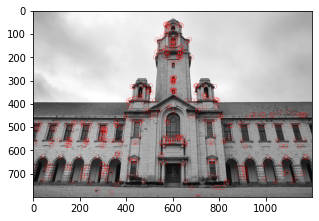

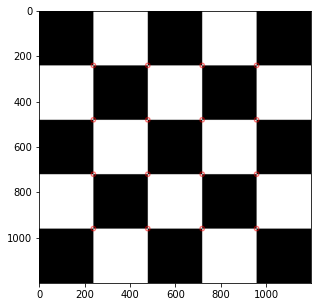

In [5]:
def harris_corner_detection(img,filename,th):
  harris_response=corner_detection(img)
  img_copy_for_corners = np.copy(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
  th=th*harris_response.max()
  for i in range(img.shape[0]):
        for j in range(img.shape[1]):
          if harris_response[i,j] > th:
            max = harris_response[i,j]
            # Local non-maxima suppression
            skip = False
            for nrow in range(5):
                for ncol in range(5):
                    if i + nrow - 2 < img.shape[0] and j + ncol - 2 < img.shape[1]:
                        if harris_response[i + nrow - 2,j + ncol - 2] > max:
                            skip = True
                            break
            if not skip:
              cv2.circle(img_copy_for_corners, (j,i), 10, [255,0,0], 1)
  plt.figure(figsize=(5,5))
  plt.imshow(img_copy_for_corners)
  plt.imsave(path+'output/hcs_'+filename+'.png',img_copy_for_corners)

harris_corner_detection(img2,'mainbuilding',0.01)
harris_corner_detection(img1,'checkerboard',0.2)

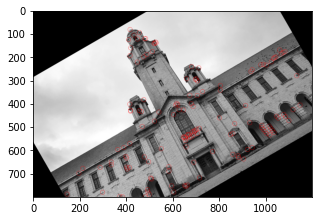

In [ ]:
import imutils

def rotate_hcs(img,filename,angle):
  image1_rot = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  img = imutils.rotate(img, angle)
  harris_corner_detection(img,filename,0.01)
rotate_hcs(img2,'mainbuilding_rotate',30)
#rotate_hcs(img1,'checkerboard_rotate',90)

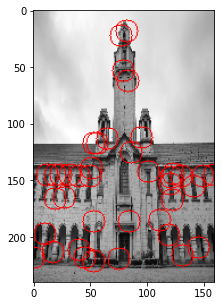

In [7]:
def scale_hcs(img,filename,k):
  img = cv2.resize(img,(int(k*img.shape[0]),int(img.shape[1]*k)))
  harris_corner_detection(img,filename,0.01)
#scale_hcs(img1,'scale_checkerboard',2)
scale_hcs(img2,'scale_mainbuilding',0.2)

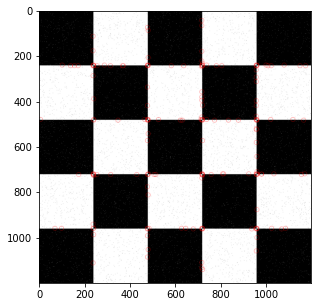

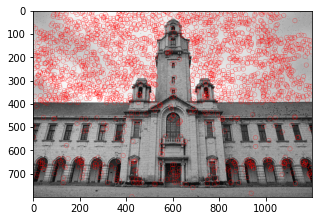

In [ ]:
from skimage.util import random_noise
def noise_hcs(img,filename):
  noise_img_1 = random_noise(img, mode='s&p',amount=0.01)
  noise_img_1 = np.array(255*noise_img_1, dtype = 'uint8')
  #plt.imshow(noise_img_1,cmap='gray')
  harris_corner_detection(noise_img_1,filename,0.1)
noise_hcs(img1,'noise_checkerboard')
noise_hcs(img2,'noise_mainbuilding')

INbuilt

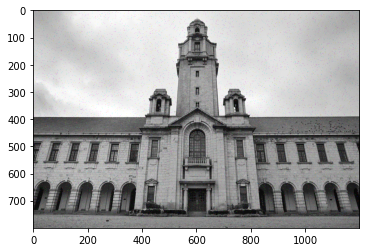

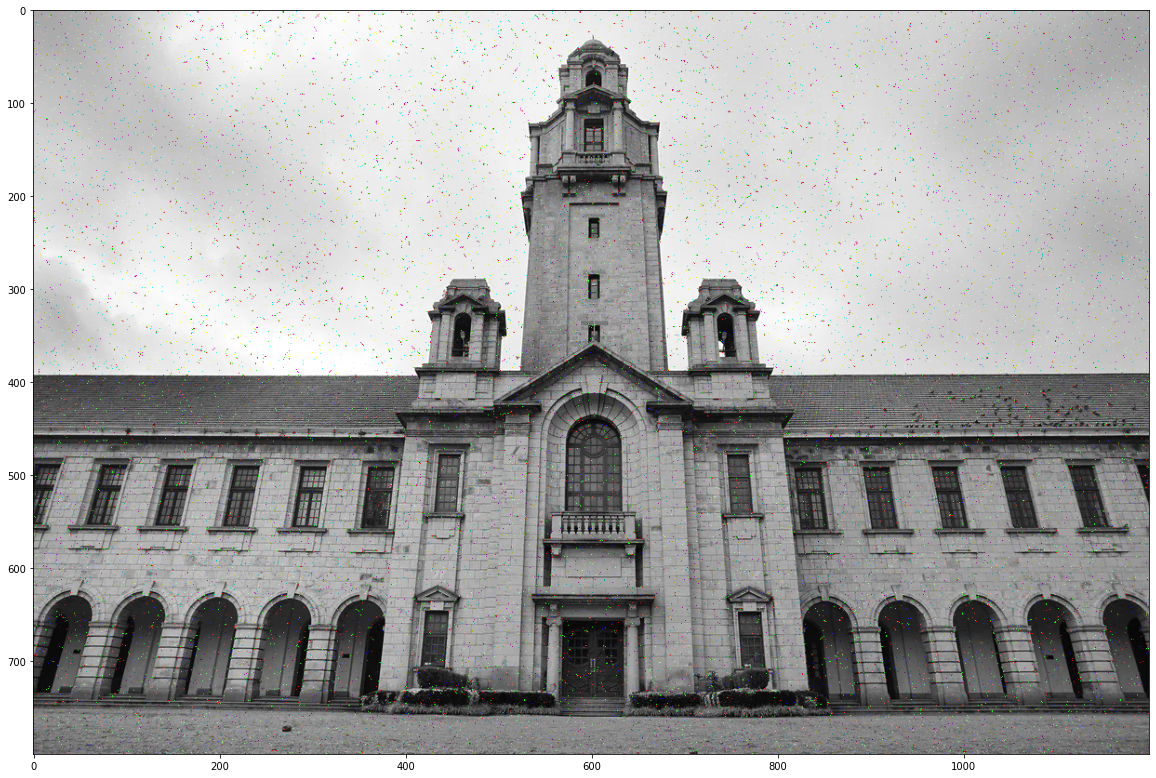

In [ ]:
import numpy as np
import cv2 as cv
from skimage.util import random_noise

filename = 'chessboard2.jpg'
img = cv.imread(path+images[1])
img = random_noise(img, mode='s&p',amount=0.01)

#img = np.array(img, dtype=np.uint8)
img = np.array(255*img, dtype = 'uint8')

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
# find Harris corners
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.06)
dst = cv.dilate(dst,None)
ret, dst = cv.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[255,0,0]
img[res[:,3],res[:,2]] = [0,255,0]
plt.figure(figsize=(20,20))
plt.imshow(img)
